In [34]:
%reset -sf

In [43]:
# LOAD THIS BEFORE START, run rmdl

#!/usr/bin/env python3
import sys
import math, random
import functools, itertools, collections, heapq, bisect
from collections import Counter, defaultdict, deque

# import numpy as np
import scipy
import matplotlib.pyplot as plt

abc = "abcdefghijklmnopqrstuvwxyz"
abc_map = {c:i for i,c in enumerate(abc)}
M9 = 10**9 + 7  # 998244353
yes, no = "YES", "NO"
d4 = [(1,0),(0,1),(-1,0),(0,-1)]
d8 = [
    (-1,-1),(-1,0),(-1,1),
    (0,-1),(0,0),(0,1),
    (1,-1),(1,0),(1,1)]
d6 = [(2,0),(1,1),(-1,1),(-2,0),(-1,-1),(1,-1)]  # hexagonal layout
MAXINT = sys.maxsize

In [273]:
with open("/Users/htong/Downloads/input.txt") as f:
    srr = f.read().strip().split("\n")

In [187]:
# srr

In [263]:
srr = """
.|...\\....
|.-.\\.....
.....|-...
........|.
..........
.........\\
..../.\\\\..
.-.-/..|..
.|....-|.\\
..//.|....
""".strip().split("\n")

In [200]:
srr = """
\\.........
..........
..........
..........
./........
\\.........
..........
..........
..........
..........
""".strip().split("\n")

In [274]:
assert len(set([len(row) for row in srr])) == 1

In [275]:
arr = [list(row) for row in srr]

In [276]:
n = len(arr)
m = len(arr[0])
maxres = 0

In [278]:
for a in [False, True]:
    for b in [False, True]:
        for sx in range(-1, n+1):
            for sy in (-1, m+1):

                # is vert, is back, x, y
                stack = [(a,b,sx,sy)]
                # stack = [(False,False,0,0)]
                visited = set(stack)
                res = set()
#                 res2 = []

                while stack:
                    cur = stack.pop()
                    is_vert, is_back, x, y = cur

                    if 0 <= x < n and 0 <= y < m:
                        res.add((x,y))
#                         if (x,y) not in res2:
#                             res2.append((x,y))

                    dx = 0
                    dy = 0
                    if is_vert:
                        if is_back:
                            dx = -1
                        else:
                            dx = 1
                    else:
                        if is_back:
                            dy = -1
                        else:
                            dy = 1

#                     print(cur, dx, dy)

                    xx, yy = x+dx, y+dy

                    if 0 <= xx < n and 0 <= yy < m:

                        if arr[xx][yy] == "/":
                            nex = (not is_vert, not is_back, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)

                        elif arr[xx][yy] == "\\":
                            nex = (not is_vert, is_back, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)


                        elif arr[xx][yy] == "-" and is_vert == True:
#                             print("-")

                            nex = (not is_vert, False, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)

                            nex = (not is_vert, True, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)

                        elif arr[xx][yy] == "|" and is_vert == False:
#                             print("|")

                            nex = (not is_vert, False, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)

                            nex = (not is_vert, True, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)

                        else:
                            nex = (is_vert, is_back, xx, yy)

                            if nex not in visited:            
                                visited.add(nex)
                                stack.append(nex)
                                
                maxres = max(maxres, len(res))
                print(a,b,sx,sy, len(res), maxres)

                #         print(stack)

False False -1 -1 0 8087
False False -1 111 0 8087
False False 0 -1 7939 8087
False False 0 111 0 8087
False False 1 -1 7957 8087
False False 1 111 0 8087
False False 2 -1 69 8087
False False 2 111 0 8087
False False 3 -1 58 8087
False False 3 111 0 8087
False False 4 -1 19 8087
False False 4 111 0 8087
False False 5 -1 7 8087
False False 5 111 0 8087
False False 6 -1 7948 8087
False False 6 111 0 8087
False False 7 -1 52 8087
False False 7 111 0 8087
False False 8 -1 11 8087
False False 8 111 0 8087
False False 9 -1 14 8087
False False 9 111 0 8087
False False 10 -1 42 8087
False False 10 111 0 8087
False False 11 -1 134 8087
False False 11 111 0 8087
False False 12 -1 7948 8087
False False 12 111 0 8087
False False 13 -1 337 8087
False False 13 111 0 8087
False False 14 -1 50 8087
False False 14 111 0 8087
False False 15 -1 36 8087
False False 15 111 0 8087
False False 16 -1 7947 8087
False False 16 111 0 8087
False False 17 -1 8097 8097
False False 17 111 0 8097
False False 18 -1 11

True False 35 -1 0 8318
True False 35 111 0 8318
True False 36 -1 0 8318
True False 36 111 0 8318
True False 37 -1 0 8318
True False 37 111 0 8318
True False 38 -1 0 8318
True False 38 111 0 8318
True False 39 -1 0 8318
True False 39 111 0 8318
True False 40 -1 0 8318
True False 40 111 0 8318
True False 41 -1 0 8318
True False 41 111 0 8318
True False 42 -1 0 8318
True False 42 111 0 8318
True False 43 -1 0 8318
True False 43 111 0 8318
True False 44 -1 0 8318
True False 44 111 0 8318
True False 45 -1 0 8318
True False 45 111 0 8318
True False 46 -1 0 8318
True False 46 111 0 8318
True False 47 -1 0 8318
True False 47 111 0 8318
True False 48 -1 0 8318
True False 48 111 0 8318
True False 49 -1 0 8318
True False 49 111 0 8318
True False 50 -1 0 8318
True False 50 111 0 8318
True False 51 -1 0 8318
True False 51 111 0 8318
True False 52 -1 0 8318
True False 52 111 0 8318
True False 53 -1 0 8318
True False 53 111 0 8318
True False 54 -1 0 8318
True False 54 111 0 8318
True False 55 -1 0 8

In [279]:
maxres

8318

In [269]:
stack

[]

In [241]:
len(res2)

0

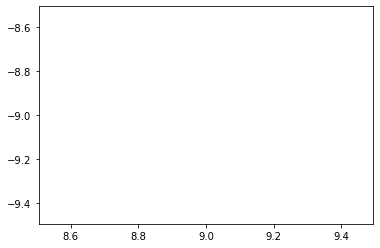

In [245]:
plt.plot([y for x,y in res], [-x for x,y in res])
plt.show()

In [221]:
(0,0) in res2

False

In [154]:
# print(res)